In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

In [18]:
# Učitaj podatke
failures_df = pd.read_csv('data/NIS_ESP_events_anonymized.csv')
telemetry_df = pd.read_csv('data/NIS_ESP_telemetry_anonymized.csv')

telemetry_df2 = telemetry_df.sample(frac=0.3)

telemetry_df2.ffill(inplace = True)
telemetry_df2.bfill(inplace = True)

telemetry_df2['measure_date'] = pd.to_datetime(telemetry_df2['measure_date'])
telemetry_df2['date'] = telemetry_df2['measure_date'].dt.date

daily_avg = telemetry_df2.groupby(['well', 'date']).mean().reset_index()
daily_avg.to_csv('daily_avg_measurements.csv', index=False)

data = pd.merge(daily_avg, failures_df, left_on='well', right_on='well', how='left')

data.dropna(subset=['date_time', 'label'], inplace=True)

In [19]:
daily_avg.head()

,well,date,Unnamed: 0,measure_date,napon_ab,napon_bc,napon_ca,elektricna_struja_fazaa,elektricna_struja_fazab,elektricna_struja_fazac,koeficijent_kapaciteta,frekvencija,radno_opterecenje,aktivna_snaga,pritisak_na_prijemu_pumpe,temperatura_motora,temperatura_u_busotini
0,well_1,2020-06-01,506.324159,2020-06-01 11:08:34.366972416,401.458716,403.562691,402.489297,14.691131,14.525994,14.375229,63.896024,30.307034,50.076453,20.728732,58.825138,117.643119,114.612878
1,well_1,2020-06-02,1604.249231,2020-06-02 11:42:12.649230592,402.972308,403.172308,401.338462,14.298462,14.550769,13.929538,67.218462,26.373538,48.793846,22.276923,58.768185,116.119077,115.822769
2,well_1,2020-06-03,2774.204082,2020-06-03 12:31:12.626822144,395.067055,398.148688,395.962099,14.638484,14.618076,14.533819,64.830904,28.675802,49.574344,21.054114,59.305102,117.067347,115.386617
3,well_1,2020-06-04,3945.590909,2020-06-04 12:00:58.152406272,393.807487,398.077540,395.144385,14.721925,14.775401,14.387701,66.318182,30.690909,50.959893,21.323705,59.466043,117.109358,116.278638
4,well_1,2020-06-05,5231.143519,2020-06-05 11:51:39.921296384,397.518519,397.861111,396.958333,14.735880,14.141204,13.953472,66.840278,28.181250,48.516204,21.879580,53.768519,118.378241,116.146991


In [20]:
# konvertovanje u datetime format
data['measure_date'] = pd.to_datetime(data['measure_date'])
data['date_time'] = pd.to_datetime(data['date_time'])
data['days_to_failure'] = (data['date_time'] - data['measure_date']).dt.days

# odabir relevantnih kolona
X = data.drop(['days_to_failure', 'measure_date', 'date_time', 'well', 'date', 'label', 'esp_type'], axis=1)
y = data['days_to_failure']

X = pd.get_dummies(X, drop_first=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Izgradnja neuronske mreže za predviđanje dana do otkaza
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [24]:
# Obuka modela
history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_split=0.2)

# Evaluacija modela
y_pred = model.predict(X_test)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 79689.4531 - mae: 167.2415 - val_loss: 84755.2500 - val_mae: 165.5872
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 83044.9688 - mae: 160.9495 - val_loss: 84011.1406 - val_mae: 163.7500
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 83040.4766 - mae: 163.2629 - val_loss: 83571.8438 - val_mae: 163.0939
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 81328.5078 - mae: 160.2923 - val_loss: 83177.4141 - val_mae: 162.9598
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 77330.4609 - mae: 156.3006 - val_loss: 82479.4688 - val_mae: 162.4417
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 78364.8281 - mae: 157.7266 - val_loss: 81481.8828 - val_mae: 162.0427
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 73874.5859 - mae: 154.4742 - val_loss: 80333.1094 - val_mae: 161.9525
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 77830.9219 - mae: 161.5383 - val_loss:

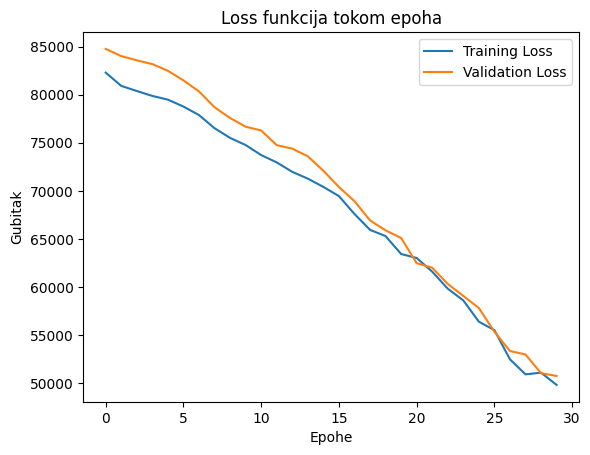

In [25]:
# Plot loss funkcija tokom treninga
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss funkcija tokom epoha')
plt.xlabel('Epohe')
plt.ylabel('Gubitak')
plt.legend()
plt.show()

In [9]:
# Kreiranje DataFrame-a sa predikcijama
test_dates = data.loc[y_test.index, 'measure_date']  # Pretpostavljam da je 'measure_date' u 'data'
test_labels = data.loc[y_test.index, 'label']  # Preuzimanje labela iz test podataka (naziv otkaza)

# Kreiraj DataFrame sa stvarnim danima, predviđenim danima i tipom otkaza
predictions_df = pd.DataFrame({
    'Actual Days to Failure': y_test, 
    'Predicted Days to Failure': y_pred.flatten(),
    'Failure Type': test_labels,  # Tip otkaza koji predviđamo
    'Date': test_dates  # Dodaj datum merenja
})

otkaziFJ = []
# Ispis predikcija sa nazivom otkaza i brojem dana
for index, row in predictions_df.iterrows():
    predicted_days = int(row['Predicted Days to Failure'])  # Predviđeni broj dana do otkaza
    actual_days = int(row['Actual Days to Failure'])  # Stvarni broj dana do otkaza
    failure_type = row['Failure Type']  # Naziv otkaza koji se predviđa
    prediction_date = row['Date'] + pd.Timedelta(days=predicted_days)  # Računanje datuma otkaza
    if predicted_days > 0:
        otkazFJ = f"Očekuje se otkaz tipa '{failure_type}' za {predicted_days} dana od {row['Date'].date()}, što je {prediction_date.date()} (stvarni otkaz za {actual_days} dana)."
    else:
        otkazFJ = f"Ne ocekuje se otkaz"
    #print(f"Očekuje se otkaz tipa '{failure_type}' za {predicted_days} dana od {row['Date'].date()}, što je {prediction_date.date()} (stvarni otkaz za {actual_days} dana).")
    otkaziFJ.append(otkazFJ)

Accuracy: 72.35%
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1315
           1       0.56      0.60      0.58       609

    accuracy                           0.72      1924
   macro avg       0.68      0.69      0.69      1924
weighted avg       0.73      0.72      0.73      1924

ROC AUC: 0.2460282080578396


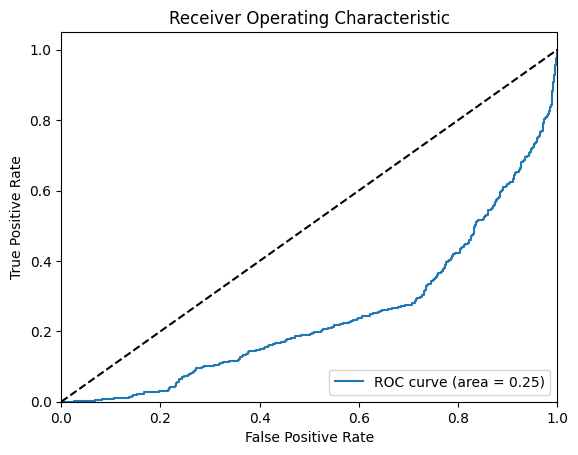

In [26]:
# Klasifikacija predikcija
threshold = 10  # granica za "uskoro" ili "daleko"
y_pred_classes = (y_pred.flatten() < threshold).astype(int)  # 1 za "uskoro", 0 za "daleko"
y_test_classes = (y_test < threshold).astype(int)  # 1 za "uskoro", 0 za "daleko"

# Izračunavanje tačnosti
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

print(classification_report(y_test_classes, y_pred_classes))
roc_auc = roc_auc_score(y_test_classes, y_pred.flatten())
print('ROC AUC:', roc_auc)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test_classes, y_pred.flatten())
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

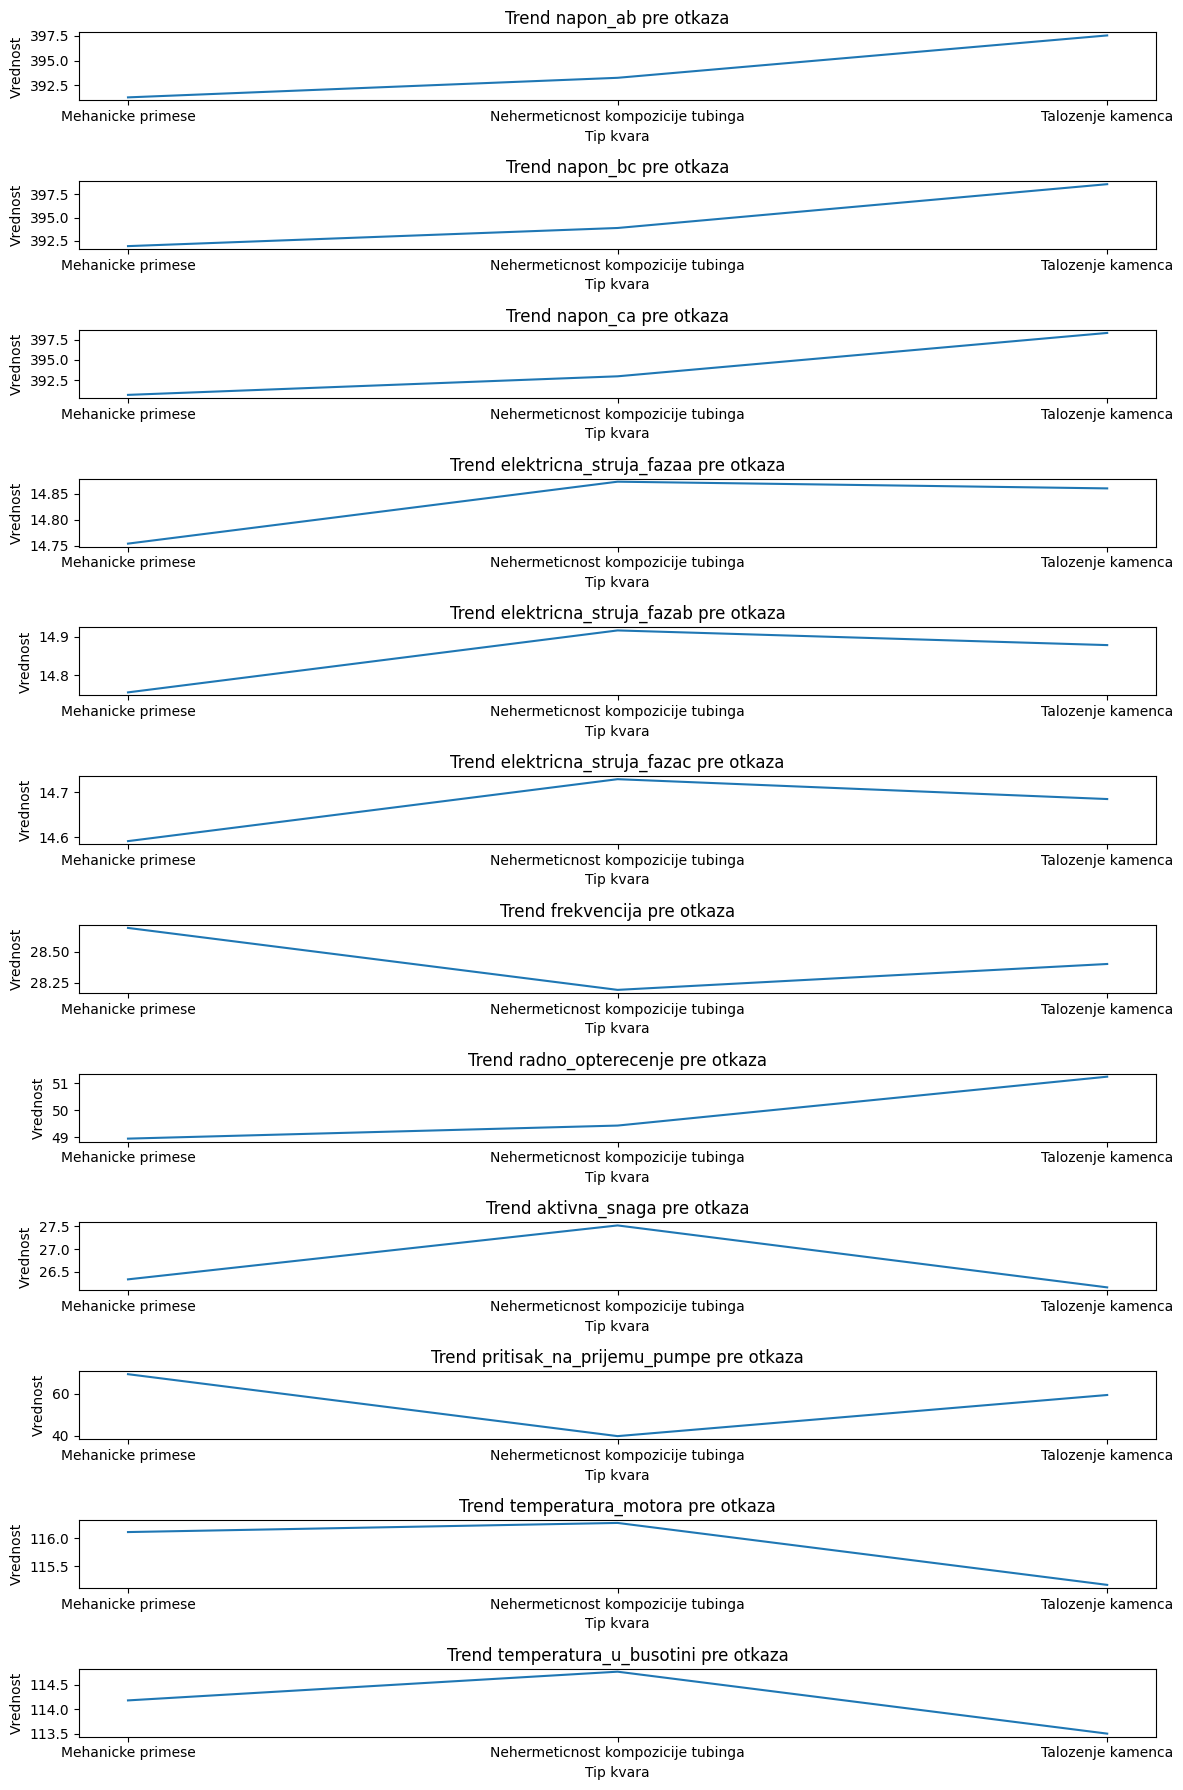

In [27]:
# 2. Analiza trendova pre otkaza
data['time_to_failure'] = (data['measure_date'] - data['date_time']).dt.total_seconds()

numeric_columns = ['napon_ab','napon_bc','napon_ca', 'elektricna_struja_fazaa','elektricna_struja_fazab','elektricna_struja_fazac',
                   'frekvencija', 'radno_opterecenje', 'aktivna_snaga',
                   'pritisak_na_prijemu_pumpe', 'temperatura_motora','temperatura_u_busotini']

# Uoči trendove za različite uzroke otkaza
trend_data = data.groupby('label')[numeric_columns].mean()

for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data = data.dropna(subset=numeric_columns)

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(12, 18))

# trendovi za svaku numeričku kolonu
for i, col in enumerate(numeric_columns):
    trend_data = data.groupby('label')[col].mean().reset_index()
    sns.lineplot(data=trend_data, x='label', y=col, ax=axes[i])
    axes[i].set_title(f'Trend {col} pre otkaza')
    axes[i].set_ylabel('Vrednost')
    axes[i].set_xlabel('Tip kvara')
    
plt.tight_layout()
plt.show()

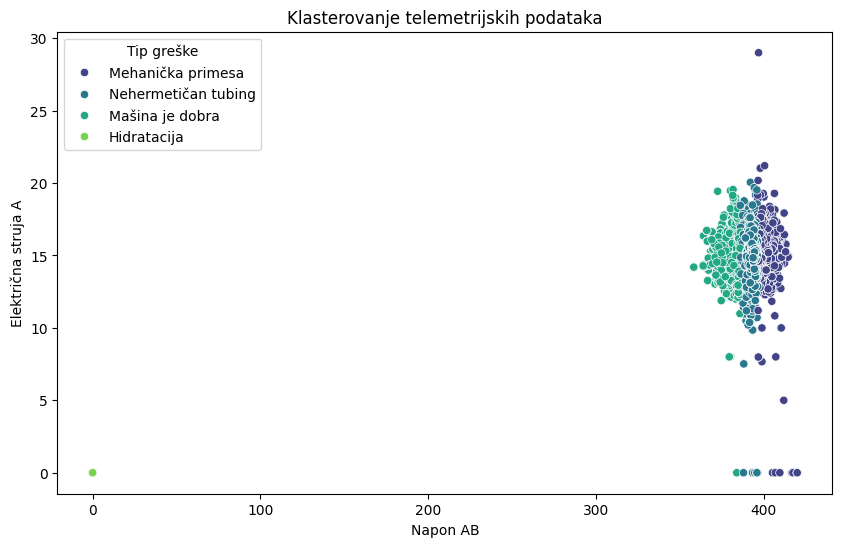

In [28]:
from sklearn.preprocessing import LabelEncoder

selected_features = [
    'napon_ab',
    'elektricna_struja_fazaa'
]

X = data[selected_features]

kmeans = KMeans(n_clusters=4, random_state=42)
data['clusters'] = kmeans.fit_predict(X)

# Kreirajte mapu klastera na naziv greške
cluster_names = {
    0: 'Mehanička primesa',
    1: 'Hidratacija',
    2: 'Nehermetičan tubing',
    3: 'Mašina je dobra'
}

# Zamenite brojeve klastera sa nazivima grešaka
data['error_type'] = data['clusters'].map(cluster_names)

# Vizualizujte klastere
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['napon_ab'], y=data['elektricna_struja_fazaa'], hue=data['error_type'], palette='viridis', legend='full')
plt.title('Klasterovanje telemetrijskih podataka')
plt.xlabel('Napon AB')
plt.ylabel('Električna struja A')
plt.legend(title='Tip greške')
plt.show()

In [29]:
print(otkaziFJ[97])
print(otkaziFJ[341])
print(otkaziFJ[642])
print(otkaziFJ[452])

Očekuje se otkaz tipa 'Talozenje kamenca' za 33 dana od 2020-04-18, što je 2020-05-21 (stvarni otkaz za -35 dana).
Očekuje se otkaz tipa 'Mehanicke primese' za 160 dana od 2022-05-12, što je 2022-10-19 (stvarni otkaz za 381 dana).
Očekuje se otkaz tipa 'Nehermeticnost kompozicije tubinga' za 28 dana od 2023-01-17, što je 2023-02-14 (stvarni otkaz za 51 dana).
Očekuje se otkaz tipa 'Nehermeticnost kompozicije tubinga' za 5 dana od 2022-09-05, što je 2022-09-10 (stvarni otkaz za -782 dana).


In [39]:
#EXPORT za Baneta
import joblib

joblib.dump(model, 'esp_failure_prediction_model.pkl')

# # Funkcija za predikciju dana do otkaza
# def predict_days_to_failure(input_data):

#     input_data_scaled = scaler.transform(input_data)
#     # Predikcija
#     predictions = model.predict(input_data_scaled)
    
#     return predictions.flatten()
# # funkcija za identifikovaciju početne pojave simptoma otkaza
# def identify_symptoms(data):
#     symptoms = []
#     threshold_values = {
#         'mehanicke_primesa': 0.8,
#         'hidrate': 0.5,
#         'nehermetican_tubing': 0.3
#     }
    
#     for index, row in data.iterrows():
#         if row['some_mechanical_indicator'] > threshold_values['mehanicke_primesa']:
#             symptoms.append((index, 'Mehaničke primese'))
#         elif row['some_hydrate_indicator'] > threshold_values['hidrate']:
#             symptoms.append((index, 'Hidrate'))
#         elif row['some_leakage_indicator'] > threshold_values['nehermetican_tubing']:
#             symptoms.append((index, 'Nehermetičan tubing'))
    
#     return symptoms
# # funkcija za utvrdjivanje karakterističnih trendova
# def analyze_trends(data):
#     trend_data = data.groupby('label')[numeric_columns].mean()
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(data=trend_data)
#     plt.title('Trendovi telemetrijskih podataka pre otkaza')
#     plt.ylabel('Vrednost')
#     plt.xlabel('Tip kvara')
#     plt.legend(numeric_columns)
#     plt.show()

def predict_failure_for_well(well_id, telemetry_df, failures_df, model, scaler):
    # Filtriraj podatke za prosleđeni well_id
    telemetry_data = telemetry_df[telemetry_df['well'] == well_id].copy()  # Kreiraj kopiju DataFrame-a
    failure_data = failures_df[failures_df['well'] == well_id]

    # Proveri da li postoje podaci za dati bunar
    if telemetry_data.empty:
        print(f"Nema podataka za bunar: {well_id}")
        return

    # Proveri da li postoji događaj otkaza
    if failure_data.empty:
        print(f"Nema zabeleženih otkaza za bunar: {well_id}")
        return

    # Obrada podataka
    #Zelim objasnjenje zasto ovo radimo?
    
    telemetry_data.ffill(inplace=True)
    telemetry_data.bfill(inplace=True)

    # Koristite .loc[] za izbegavanje upozorenja
    telemetry_data['measure_date'] = pd.to_datetime(telemetry_data['measure_date'], errors='coerce')

    # Provera da li su sve vrednosti uspešno konvertovane
    if telemetry_data['measure_date'].isnull().any():
        print("Neki podaci u koloni 'measure_date' nisu pravilno konvertovani u datetime.")
        return

    # Kreiraj novu kolonu 'date' na osnovu 'measure_date'
    telemetry_data['date'] = telemetry_data['measure_date'].dt.date

    # Izračunaj dnevne prosek merenja
    daily_avg = telemetry_data.groupby(['well', 'date']).mean().reset_index()

    # Spoji sa podacima o otkazima
    data = pd.merge(daily_avg, failure_data, left_on='well', right_on='well', how='left')
    data.dropna(subset=['date_time', 'label'], inplace=True)

    # Konvertovanje u datetime format
    data['measure_date'] = pd.to_datetime(data['measure_date'])
    data['date_time'] = pd.to_datetime(data['date_time'])
    data['days_to_failure'] = (data['date_time'] - data['measure_date']).dt.days

    # Izbacivanje ne relevantnih kolona
    X = data.drop(['days_to_failure', 'measure_date', 'date_time', 'well', 'date', 'label', 'esp_type'], axis=1)
    
    # Ako su potrebne dummies, uradi to
    X = pd.get_dummies(X, drop_first=True)

    # Skaliranje
    X_scaled = scaler.transform(X)

    # Predikcija
    y_pred = model.predict(X_scaled)

    # Kreiranje DataFrame-a sa predikcijama
    failure_type_mapping = {
        0: 'Mehanička primesa',
        1: 'Hidratacija',
        2: 'Nehermetičan tubing',
        3: 'Nema otkaza'
    }

    predicted_days = int(y_pred.flatten()[0])  # Uzimamo prvi rezultat
    failure_type_index = int(np.round(predicted_days / 10))  # Pretpostavljamo da koristimo klastere
    failure_type = failure_type_mapping.get(failure_type_index, 'Nepoznato')

    # Izračunavanje datuma otkaza
    prediction_date = data['measure_date'].iloc[-1] + pd.Timedelta(days=predicted_days)

    print(f"Očekuje se otkaz za bunar '{well_id}' za {predicted_days} dana ({failure_type}) na datum {prediction_date.date()}.")

failures_dfB = pd.read_csv('test1.csv')
telemetry_dfB = pd.read_csv('test2.csv')

# Primer poziva funkcije
well_ids = ['well_1','well_1','well_1']
for i in range(3):
    predict_failure_for_well(well_ids[i], telemetry_dfB, failures_dfB, model, scaler)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Očekuje se otkaz za bunar 'well_1' za 364 dana (Nepoznato) na datum 2022-12-19.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Očekuje se otkaz za bunar 'well_1' za 364 dana (Nepoznato) na datum 2022-12-19.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Očekuje se otkaz za bunar 'well_1' za 364 dana (Nepoznato) na datum 2022-12-19.


In [40]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

matplotlib==3.9.2
keras==3.5.0
tensorflow==2.17.0
pandas==2.2.2
numpy==1.26.4
scikit-learn==1.5.1
joblib==1.4.2
seaborn==0.13.2
imblearn==0.0
